# 1. Understand the Data

    a)Load the Data: Start by loading the dataset and understanding its structure.
    b)Check Data Types: Ensure the timestamp column is in the correct datetime format.

In [ ]:
import pandas as pd
file_path = r"C:\Users\UDAY\Documents\sairam\data\memory_usage.csv"
df = pd.read_csv(file_path, parse_dates=['timestamp'])
print(df.dtypes)

In [ ]:
df.head()

In [ ]:
pip install tensorflow


In [ ]:
import numpy as np
%matplotlib inline
import pandas as pd
import tensorflow as tf
from IPython.display import display, Image
import cv2
from PIL import Image
from tqdm import tqdm
from keras.applications.vgg19 import VGG19
import gc
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 2. Visualize the Data

Plot the Time Series: Plot the data to get a visual understanding of trends, seasonality, and any irregularities.

Matplotlib is building the font cache; this may take a moment.


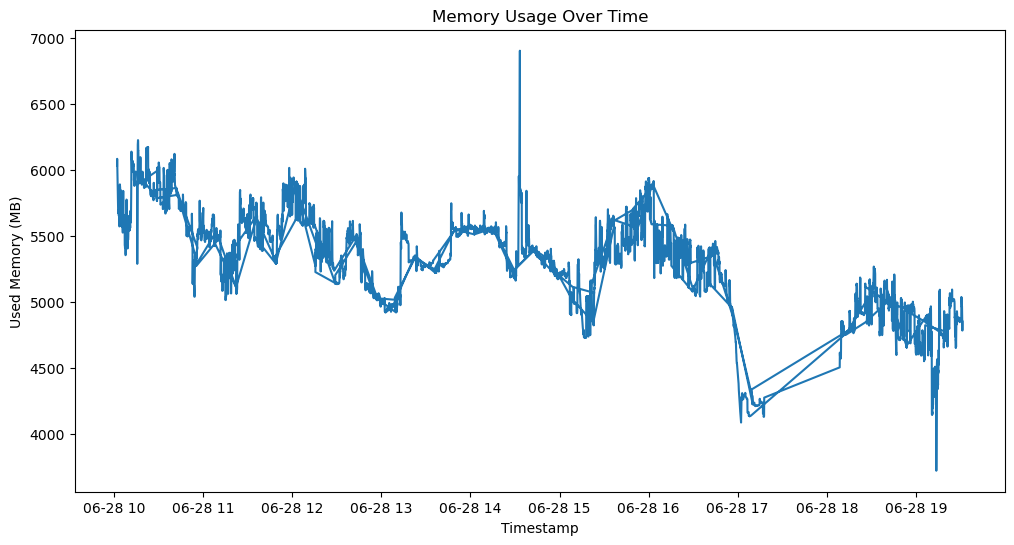

In [7]:
 import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['used_memory_mb'])
plt.title('Memory Usage Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Used Memory (MB)')
plt.show()


# 3. Handle Missing Values

    Check for Missing Values: Identify any missing values in the dataset.

In [7]:
print(df.isnull().sum())


timestamp              0
total_memory_mb        0
available_memory_mb    0
used_memory_mb         0
percent_memory         0
dtype: int64


# 4.Check for Stationarity

    Stationarity: A time series is stationary if its statistical properties (mean, variance) do not change over time. Many time series models assume the data is stationary.

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['used_memory_mb'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])


# 5 Decompose the Time Series

Decompose: Decompose the series into trend, seasonal, and residual components to better understand its structure

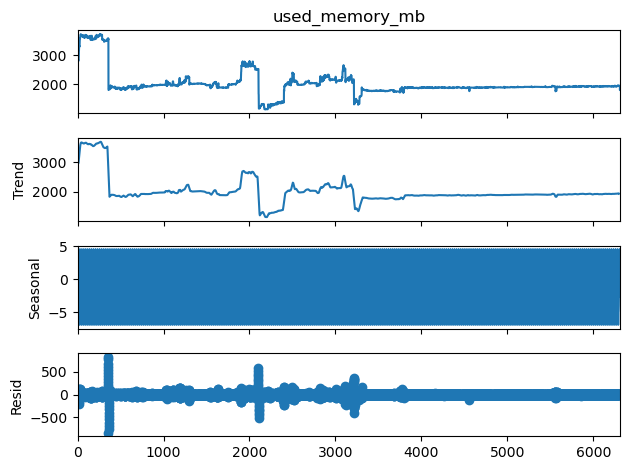

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df['used_memory_mb'], model='additive', period=24)
decomposition.plot()
plt.show()


# 7. Lag Features

    Lag Features: Create lag features to capture the temporal dependencies in the data.

In [11]:
for lag in range(1, 8):  # Creating 7 lag features
    df[f'lag_{lag}'] = df['used_memory_mb'].shift(lag)
df = df.dropna()
df

,timestamp,total_memory_mb,available_memory_mb,used_memory_mb,percent_memory,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
7,2024-06-22 10:27:20,5853.62,2718.15,2804.76,53.6,2826.45,2830.22,2802.00,2814.12,2812.30,2814.33,2812.16
8,2024-06-22 10:27:25,5853.62,2694.43,2807.90,54.0,2804.76,2826.45,2830.22,2802.00,2814.12,2812.30,2814.33
9,2024-06-22 10:27:30,5853.62,2700.42,2807.61,53.9,2807.90,2804.76,2826.45,2830.22,2802.00,2814.12,2812.30
10,2024-06-22 10:27:35,5853.62,2702.50,2804.92,53.8,2807.61,2807.90,2804.76,2826.45,2830.22,2802.00,2814.12
11,2024-06-22 10:27:40,5853.62,2695.82,2814.95,53.9,2804.92,2807.61,2807.90,2804.76,2826.45,2830.22,2802.00
...,...,...,...,...,...,...,...,...,...,...,...,...
6305,2024-06-22 22:05:50,5853.62,3587.00,1943.27,38.7,1943.29,1943.84,1947.16,1945.44,1938.07,1937.65,1938.15
6306,2024-06-22 22:05:55,5853.62,3606.60,1923.65,38.4,1943.27,1943.29,1943.84,1947.16,1945.44,1938.07,1937.65
6307,2024-06-22 22:06:00,5853.62,3594.36,1935.98,38.6,1923.65,1943.27,1943.29,1943.84,1947.16,1945.44,1938.07
6308,2024-06-22 22:06:05,5853.62,3733.32,1797.98,36.2,1935.98,1923.65,1943.27,1943.29,1943.84,1947.16,1945.44


# 8. Train-Test Split

    Split the Data: Split the data into training and testing sets based on time.

In [12]:
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]


# 9. Scale the Data

    Normalization: Normalize the data to scale the features between 0 and 1, which is important for LSTM models.

In [14]:
 from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[['used_memory_mb']])
test_scaled = scaler.transform(test[['used_memory_mb']])


In [29]:
def train_generator(df, n_lags=1):
    dataX, dataY = [], []
    for i in range(len(df) - n_lags - 1):
        a = df.iloc[i:(i + n_lags)].to_numpy()
        dataX.append(a)
        dataY.append(df.iloc[i + n_lags].to_numpy())
    return np.array(dataX), np.array(dataY)


In [30]:
TIME_STEPS = 500
X_train, y_train = train_generator(train_scaled, n_lags = TIME_STEPS)
X_test_scaled, y_test_scaled = train_generator(test_scaled, n_lags = TIME_STEPS)
X_test, y_test = train_generator(test, n_lags = TIME_STEPS)

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [22]:
import tensorflow as tf

# Assuming X_train shape is (number of samples, time steps, number of features)
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(512, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(tf.keras.layers.LSTM(512, return_sequences=False))
model.add(tf.keras.layers.Dense(3))  # Assuming you have 3 output units

# Print model summary
model.summary()


NameError: name 'X_train' is not defined

In [33]:
def train_generator(df, n_lags):
    dataX, dataY = [], []
    for i in range(len(df) - n_lags - 1):
        a = df.iloc[i:(i + n_lags)].to_numpy()  # Accessing DataFrame correctly
        dataX.append(a)
        dataY.append(df.iloc[i + n_lags].to_numpy())
    return np.array(dataX), np.array(dataY)
TIME_STEPS = 500

# Assuming train_scaled and test_scaled are NumPy arrays
# Convert them to Pandas DataFrames or Series before passing to train_generator
X_train, y_train = train_generator(pd.DataFrame(train_scaled), n_lags=TIME_STEPS)
X_test_scaled, y_test_scaled = train_generator(pd.DataFrame(test_scaled), n_lags=TIME_STEPS)
X_test, y_test = train_generator(pd.DataFrame(test), n_lags=TIME_STEPS)


In [32]:
import pandas as pd
import numpy as np  # Ensure NumPy is imported

# Define train_generator function
def train_generator(df, n_lags):
    dataX, dataY = [], []
    for i in range(len(df) - n_lags - 1):
        a = df.iloc[i:(i + n_lags)].to_numpy()
        dataX.append(a)
        dataY.append(df.iloc[i + n_lags].to_numpy())
    return np.array(dataX), np.array(dataY)  # Use np.array to convert lists to NumPy arrays

# Assuming train_scaled and test_scaled are NumPy arrays
# Convert them to Pandas DataFrames or Series before passing to train_generator
X_train, y_train = train_generator(pd.DataFrame(train_scaled), n_lags=TIME_STEPS)
X_test_scaled, y_test_scaled = train_generator(pd.DataFrame(test_scaled), n_lags=TIME_STEPS)
X_test, y_test = train_generator(pd.DataFrame(test), n_lags=TIME_STEPS)


In [34]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(512,input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True))
model.add(tf.keras.layers.LSTM(512,return_sequences=False))
model.add(tf.keras.layers.Dense(3))
model.summary()

/home/rgukt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 500, 512)       │     1,052,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 512)            │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,153,411 (12.03 MB)

 Trainable params: 3,153,411 (12.03 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
model.compile(loss='mean_absolute_error', optimizer= tf.keras.optimizers.Adam())

In [36]:
es = tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=8, verbose=1, restore_best_weights=True)
lr_red = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose=1, min_lr=0.0000001,)


In [ ]:
callbacks = [es , lr_red]
history = model.fit(X_train, y_train,
                    epochs=25,
                    validation_split=0.25,
                    batch_size=256,
                    verbose=1,
                    shuffle=False,
                    callbacks = callbacks)

Epoch 1/25


2024-06-25 18:40:35.911012: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 262144000 exceeds 10% of free system memory.
2024-06-25 18:40:36.705644: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 262144000 exceeds 10% of free system memory.
2024-06-25 18:42:34.049877: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 262144000 exceeds 10% of free system memory.
